<a href="https://colab.research.google.com/github/leticiaram/Modelacion-Epidemiologica/blob/main/2_Ajuste_Numerico_modelo_SIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando y cargando paquetes

In [6]:
!pip install lmfit
from lmfit import minimize, Parameters, Parameter, report_fit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00


In [1]:
import scipy.integrate as spi
import numpy as np
import pylab as pl

In [5]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')
from scipy.integrate import odeint


# Modelo SIR

In [7]:
def ode_SIR(INP,t,ps):
    try:
        beta = ps['beta'].value
        gamma = ps['gamma'].value
        N = ps['N'].value
    except:
        beta,gamma,N = ps

    Y = np.zeros((3))
    V = INP
    Y[0] = - beta * V[0] * V[1] /N
    Y[1] = beta * V[0] * V[1]/N - gamma * V[1]
    Y[2] = gamma * V[1]
    return Y


# Solución numérica del modelo

In [8]:
def g(t,INP,ps):
    SOL = spi.odeint(ode_SIR,INPUT,t_range,args=(ps,))
    return SOL

# Función que reporta los residuales

In [9]:
def residual(ps,ts,data):
    INP = ps['S0'].value, ps['I0'].value, 0.0
    model = g(ts,INP,ps)
    return (model-data).ravel()

# Ejemplo

## Simulamos datos con las siguientes condiciones iniciales y parámetros

In [10]:
beta = 1.42
gamma = 0.142
N = 1000
true_params = np.array((beta, gamma,N))

S0 = 1000-1
I0 = 1
INPUT = (S0, I0, 0.0)

t_start = 0.0; t_end = 70; t_inc = 1.0
t_range = np.arange(t_start, t_end+t_inc, t_inc)

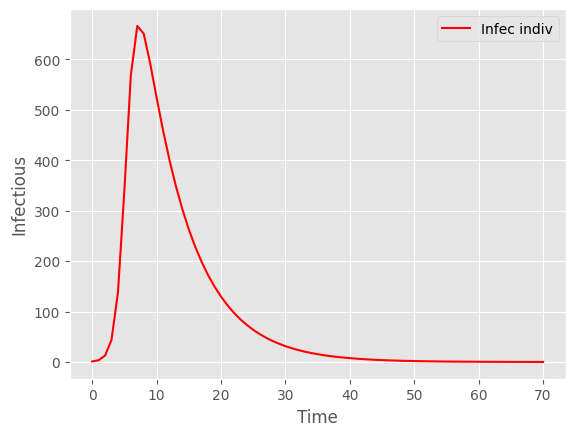

In [11]:
data = g(t_range,INPUT, true_params)
#Ploting
pl.plot(data[:,1], '-r', label='Infec indiv')
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Infectious')
pl.show()

## Los datos son la solución anterior más ruido

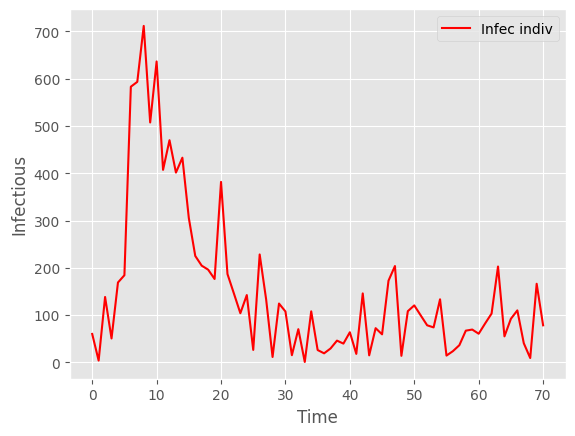

In [18]:
np.random.seed(34)

data += np.random.normal(size=data.shape,scale=60)
data = abs(data)
#Ploting
pl.plot(data[:,1], '-r', label='Infec indiv')
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Infectious')
pl.show()

## Para ajustar los valores de los parámetros, establecemos rangos factibles

In [13]:
# set parameters incluing bounds
params = Parameters()
params.add('beta', value=2.0, min=0, max=10)
params.add('gamma', value=1.0, min=0, max=10)
params.add('N', value=float(data[0, 1]), min=N, max=N+1)
params.add('S0', value= float(data[0, 0]), min=0, max=1000)
params.add('I0', value=float(data[0, 1]), min=0, max=1000)

In [14]:
# fit model and find predicted values
t = np.linspace(0, 10, 100)
result = minimize(residual, params, args=(t, data), method='leastsq')

final = data + result.residual.reshape(data.shape)
result

## Graficamos los datos y la curva del modelo ajustado

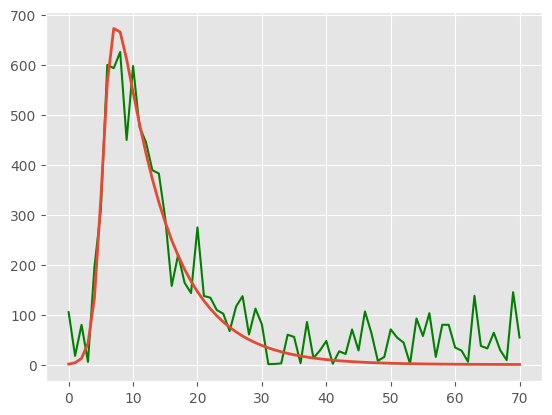

In [15]:
# plot data and fitted curves
pl.plot(data[:,1], '-g')
pl.plot(final[:,1], '-', linewidth=2);